# 0.0 Import modules

In [182]:
# === Switch to kernel bw25! ===

# Brightway libraries
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw_processing as bwp
import bw2analyzer as ba

# General libraries
import numpy as np
import pandas as pd
from fs.zipfs import ZipFS
import json                        # Library for working with json files
from pathlib import Path           # Library for working with paths in different OS     
import matplotlib.pyplot as plt    # Library for creating plots
from collections import defaultdict

# 0.1 set up project

In [183]:
bd.projects.set_current('ei38-teaching-25')

In [184]:
#if 'ei38-teaching-25' not in bd.projects:
bi.restore_project_directory(r"C:\Users\cko\sciebo1\01_CK\01_Work\1_FCN-ESE\04_Modelle\LCA_Brightway\Autumn_School\brightway2-project-ei38-teaching-25-backup.26-October-2022-03-35PM.tar.gz")

Restoring project backup archive - this could take a few minutes...


'ei38-teaching-25'

In [185]:
bd.databases

Databases dictionary with 4 object(s):
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	biosphere3
	ei 3.8 cutoff

In [186]:
#Instantiating a new project
###
#setup brightway
#bd.projects.set_current('powerplants_LCA')
#bi.bw2setup()

In [187]:
# ### variables

# db_version = "38_cut"


In [188]:
# ## dictonaries for options
# bi.create_core_migrations()

# del bd.Databases['ecoinvent 3.8_cutoff_ecoSpold02']

# db_versions = {"371_cut": 'ecoinvent 3.7.1_cutoff_ecoSpold02', "38_cut": 'ecoinvent 3.8_cutoff_ecoSpold02', "38_cons":'ecoinvent 3.8_consequential_ecoSpold02', "38_cut": 'ecoinvent 3.8_cutoff_ecoSpold02', "38_cut_test":'ecoinvent 3.8_cutoff_ecoSpold02_test'}

# #importing requiered database (ecoinvent):
# #ecoinvent
# if db_versions[db_version] in bi.databases:
#     print("Database has already been imported.")
# else:
#     fpei =r'C:\Users\cko\sciebo1\01_CK\01_Work\1_FCN-ESE\04_Modelle\LCA_Brightway\Databases/'+db_versions[db_version]+'/datasets'
#     ei = bi.SingleOutputEcospold2Importer(fpei, db_versions[db_version])
#     ei
#     ei.apply_strategies()
#     ei.statistics()
#     ei.write_database()



In [189]:
bi.databases

Databases dictionary with 4 object(s):
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	biosphere3
	ei 3.8 cutoff

In [190]:
eiDB = bd.Database('ei 3.8 cutoff')

# 0.3 read in variables

In [191]:
# electrification: yes/no?
binary_var_electrification = 1 #1=electrification, 0=no electrifaction

flex_demand = 1 #1=yes , 0=no
percentage_cut_off = 0.05
flex_percent=0.2

max_count_hours = 8760

#which process?
process_name = 'polyethylene terephthalate production, granulate, bottle grade'
process_loc = 'RER'

method = ('IPCC 2013', 'climate change', 'GWP 100a')



# 1.Electricity

## 1.1 Import electricity mix and load profile

In [192]:
scenario_year = 2025
weather_year= 2012
sector = 'Chemical & petrochemical'

file_name_em= 'assets/Results_dispatched_power_'+str(scenario_year)+'_'+str(weather_year)+'.csv'
file_name_lp = 'assets/load_profiles_all.csv'


In [193]:
if scenario_year == 2021:
    df_elecmix= pd.read_csv(file_name_em, index_col=0, sep=';')
else:  
    df_elecmix= pd.read_csv(file_name_em, index_col=0)

df_load=pd.read_csv(file_name_lp, sep=';')


In [194]:
load_profile = pd.DataFrame()
load_profile['raw'] = df_load[sector] 

In [195]:
df_elecmix=df_elecmix.divide(df_elecmix.sum(axis=1), axis=0)
#df_elecmix_norm_year = df_elecmix/8760

In [196]:
share_pp_el_DE_2021 = df_elecmix.sum()/8760

In [197]:
# available power plants
dic_powerplants= {'lignite':['li_st'], 'hardcoal':['hc_cc','hc_st'], 'nuclear':['nu'],'naturalgas': ['ng_cc', 'ng_ce', 'ng_gt', 'ng_st'], 'solar': ['so_ro','so_op'], 'wind': ['wi_off','wi_on'],'biomass': ['bm_st'], 'hydro' : ['hy_rs','hy_rr']}

dic_powerplants_market=defaultdict(float)

In [198]:
dic_powerplants_2= {'el_bio_chp':'bm_st',
'el_hydro_reservoir':'hy_rs',
'el_wind_onshore_medium':'wi_on',
'el_wind_offshore':'wi_off',
'el_pv_roof':'so_ro',
'el_nuclear_pressure':'nu'
,'el_lg':'li_st'
,'cc_hc':'hc_cc'
,'el_ng_cc':'ng_cc',
'el_hc':'hc_st',
'el_ng_cc':'ng_cc',
'el_hc':'hc_st',
'el_ng_conv':'ng_ce',
'el_ng_turb':'ng_gt',
'el_ng_conv':'ng_st',
'el_pv_openfield':'so_op',
'el_hydro_runriver':'hy_rr'}

In [199]:
list_pp_EMM = df_elecmix.columns

In [200]:
#dictonary for all  
dic_el_mix = {}

# hard coal
el_hc = eiDB.search("electricity production, hard coal", filter={'location':"DE"})
el_hc = el_hc[0]
dic_el_mix['el_hc']=el_hc

cc_hc = eiDB.search("heat and power co-generation, hard coal", filter={'location':"DE"})
cc_hc = cc_hc[0]
dic_el_mix['cc_hc']=cc_hc

# lignite
el_lg = eiDB.search("electricity production, lignite", filter={'location':"DE"})
el_lg = el_lg[0]
dic_el_mix['el_lg']=el_lg

# wind
el_wind_onshore_medium = eiDB.search("electricity production, wind, 1-3MW turbine, onshore", filter={'location':"DE"})
el_wind_onshore_medium = el_wind_onshore_medium [0]
dic_el_mix['el_wind_onshore_medium']=el_wind_onshore_medium

el_wind_onshore_small = eiDB.search("electricity production, wind, <1MW turbine, onshore", filter={'location':"DE"})
el_wind_onshore_small = el_wind_onshore_small [0]
dic_el_mix['el_wind_onshore_small']=el_wind_onshore_small

el_wind_onshore_large = eiDB.search("electricity production, wind, >3MW turbine, onshore", filter={'location':"DE"})
el_wind_onshore_large = el_wind_onshore_large [0]
dic_el_mix['el_wind_onshore_large']=el_wind_onshore_large

el_wind_offshore = eiDB.search("electricity production, wind, 1-3MW turbine, offshore", filter={'location':"DE"})
el_wind_offshore =el_wind_offshore [0]
dic_el_mix['el_wind_offshore']=el_wind_offshore

# photovoltaic
el_pv_roof = eiDB.search("electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted", filter={'location':"DE"})
el_pv_roof = el_pv_roof[0]
dic_el_mix['el_pv_roof']=el_pv_roof


el_pv_openfield = eiDB.search("electricity production, photovoltaic, 570kWp open ground installation, multi-Si", filter={'location':"DE"})
el_pv_openfield = el_pv_openfield[0]
dic_el_mix['el_pv_openfield']=el_pv_openfield

## natural gas
el_ng_10MW = eiDB.search("electricity production, natural gas, 10MW", filter={'location':"DE"})
el_ng_10MW =el_ng_10MW [0]
dic_el_mix['el_ng_10MW']=el_ng_10MW

el_ng_cc = eiDB.search("electricity production, natural gas, combined cycle power plant", filter={'location':"DE"})
el_ng_cc=el_ng_cc[0]
dic_el_mix['el_ng_cc']=el_ng_cc

el_ng_conv = eiDB.search("electricity production, natural gas, conventional power plant", filter={'location':"DE"})
el_ng_conv= el_ng_conv[0]
dic_el_mix['el_ng_conv']=el_ng_conv

el_ng_turb = eiDB.search("natural gas, burned in gas turbine, for compressor station", filter={'location':"DE"})
el_ng_turb=el_ng_turb[0]
dic_el_mix['el_ng_turb']=el_ng_turb

# nuclear
el_nuclear_boiling = eiDB.search("electricity production, nuclear, boiling water reactor", filter={'location':"DE"})
el_nuclear_boiling= el_nuclear_boiling[0]
dic_el_mix['el_nuclear_boiling']=el_nuclear_boiling

el_nuclear_pressure = eiDB.search("electricity production, nuclear, pressure water reactor", filter={'location':"DE"})
el_nuclear_pressure=el_nuclear_pressure[0]
dic_el_mix['el_nuclear_pressure']=el_nuclear_pressure

# biomass
el_bio_chp = eiDB.search("heat and power co-generation, biogas, gas engine", filter={'location':"DE"})
el_bio_chp= el_bio_chp[0]
dic_el_mix['el_bio_chp']=el_bio_chp


# hydro
el_hydro_pumpstorage = eiDB.search("electricity production, hydro, pumped storage",filter={'location':"DE"})
el_hydro_pumpstorage=el_hydro_pumpstorage[0]
dic_el_mix['el_hydro_pumpstorage']=el_hydro_pumpstorage

el_hydro_reservoir = eiDB.search("electricity production, hydro, reservoir, non-alpine region",filter={'location':"DE"})
el_hydro_reservoir= el_hydro_reservoir[0]
dic_el_mix['el_hydro_reservoir']=el_hydro_reservoir

el_hydro_runriver = eiDB.search("electricity production, hydro, run-of-river",filter={'location':"DE"})
el_hydro_runriver=el_hydro_runriver[0]
dic_el_mix['el_hydro_runriver']=el_hydro_runriver

# low voltage – energy mix 2020
el_lowvoltage = eiDB.search("market for electricity, low voltage",filter={'location':"DE"}) ##anpassen! 
el_lowvoltage =el_lowvoltage[0]
dic_el_mix['el_lowvoltage']=el_lowvoltage

# high voltage – energy mix 2020
el_highvoltage = eiDB.search("market for electricity, high voltage",filter={'location':"DE"})
el_highvoltage =el_highvoltage[0]
dic_el_mix['el_highvoltage']=el_highvoltage

Excluding 164 filtered results
Excluding 42 filtered results
Excluding 79 filtered results
Excluding 196 filtered results
Excluding 94 filtered results
Excluding 196 filtered results
Excluding 190 filtered results
Excluding 113 filtered results
Excluding 55 filtered results
Excluding 10 filtered results
Excluding 530 filtered results
Excluding 422 filtered results
Excluding 7 filtered results
Excluding 53 filtered results
Excluding 55 filtered results
Excluding 110 filtered results
Excluding 141 filtered results
Excluding 30 filtered results
Excluding 185 filtered results
Excluding 739 filtered results
Excluding 960 filtered results


In [201]:

dic_powerplants_el_DE_market = defaultdict(float)
for ECO, EMM in dic_powerplants_2.items():
    if EMM in list_pp_EMM:
        #dic_powerplants_el_DE_market[dic_el_mix[ECO]['name']] = share_pp_el_DE_2021[EMM] ##for export!
        dic_powerplants_el_DE_market[dic_el_mix[ECO]] = share_pp_el_DE_2021[EMM]    

    #print(dic_el_mix[ECO]['name'])

#df = pd.DataFrame(dic_powerplants_el_DE_market, index=[0])
#df.to_csv('shares_electr_DE_2030.csv')

In [202]:
# # available power plants
# dic_powerplants= {'lignite':['li_st'], 'hardcoal':['hc_cc','hc_st'], 'nuclear':['nu'],'naturalgas': ['ng_cc', 'ng_ce', 'ng_gt', 'ng_st'], 'solar': ['so_ro','so_op'], 'wind': ['wi_off','wi_on'],'biomass': ['bm_st'], 'hydro' : ['hy_rs','hy_rr']}

# dic_powerplants_market=defaultdict(float)

## 1.2 Flexible demand

In [203]:
## lca of power plants
# dic with co2 emission of powerplants

dic_gwp_powerplants={}

for act, amount in dic_powerplants_el_DE_market.items():
    _, data_objs, _ = bd.prepare_lca_inputs({act: 1}, method)
    lca = bc.LCA({act.id: 1}, data_objs=data_objs)
    lca.lci()
    lca.lcia()
    lca.score
    dic_gwp_powerplants[act]=lca.score


In [204]:
dic_GWP_elecmix_EMM = defaultdict(float)
for ECO, EMM in dic_powerplants_2.items():
    if EMM in list_pp_EMM:
        dic_GWP_elecmix_EMM[EMM] = dic_gwp_powerplants[dic_el_mix[ECO]]


In [205]:
list_pp = dic_GWP_elecmix_EMM.keys()


In [206]:
df_GWP_elecmix = pd.DataFrame()

In [207]:
for idpp, pp in enumerate(list_pp):
    df_GWP_elecmix[pp]=df_elecmix[pp].multiply(dic_GWP_elecmix_EMM[pp])

In [208]:
df_GWP_elecmix['sum'] = df_GWP_elecmix.sum(axis=1)

In [209]:
#df_GWP_elecmix.to_csv('GWP_elecmix_2021.csv')

In [210]:
min_GWP= df_GWP_elecmix['sum'].sort_values()[percentage_cut_off*8760]
max_GWP= df_GWP_elecmix['sum'].sort_values()[(1-percentage_cut_off)*8760]


In [211]:
load_profile['flex'] = load_profile['raw']

In [212]:
count_hours_flex = 0

for i in range(0,8760):
    if count_hours_flex <max_count_hours:
        if df_GWP_elecmix['sum'][i]>max_GWP:
            load_profile['flex'] [i] = load_profile['raw'][i]*(1-flex_percent)
            count_hours_flex += 1
        
        if df_GWP_elecmix['sum'][i]<min_GWP:
            load_profile['flex'][i] = load_profile['raw'][i]*(1+flex_percent)
            count_hours_flex += 1

<AxesSubplot:>

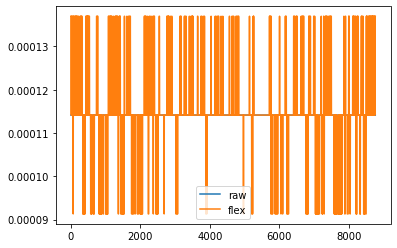

In [213]:
load_profile.plot()

In [214]:
# df_prod_ut=df_elecmix.mul(load_profile, axis=0)
# list_pp = df_prod_ut.columns
# dyn_amount_pp = df_prod_ut.sum()

## 2.0 Replace heat and electricity

In [215]:
process = eiDB.search(process_name, filter={'location':process_loc})
process = process[0]

Excluding 5 filtered results


In [216]:
heat_acts=[act for act in eiDB if 'heat production' in  act['name']
#and ('RER' in act['location'] or 'DE' in act['location'] or 'Europe without Switzerland' in act['location'])
#and 'heat' in act['reference product'] 
and 'heat pump' not in act['name']
and 'biomethane' not in act['name']
#and ('natural gas' in act['name'] or 'anthracite' in act['name'])
]

In [217]:
elek_acts=[act for act in eiDB if 'market for electricity' in  act['name']
#and ('RER' in act['location'] or 'DE' in act['location'] or 'Europe without Switzerland' in act['location'])
#and 'heat' in act['reference product'] 
#and 'heat pump' not in act['name']
#and 'biomethane' not in act['name']
#and ('natural gas' in act['name'] or 'anthracite' in act['name'])
]

In [218]:
def recurse_supply(act,max_depth, dic_heat_remove = defaultdict(float), dic_el_remove= defaultdict(float)):
    global depth
    for exc in act.technosphere():
        if exc.input in heat_acts:
            #flow_list.append(np.array((exc.input.id, exc.output.id), bwp.INDICES_DTYPE))
            dic_heat_remove[exc.input] = exc['amount']
            #print(exc.input)
        elif exc.input in elek_acts:
            dic_el_remove[exc.input] = exc['amount']
        elif depth< max_depth:
            depth +=1 
            dic_heat_remove, dic_el_remove= recurse_supply(exc.input, max_depth, dic_heat_remove, dic_el_remove)
    depth -= 1
    return dic_heat_remove, dic_el_remove

In [219]:
def replace_electricity_heat(counter, df_results, dic_powerplants_market, process_name,process_loc, method, binary_var_electrification, max_depth):
    process = eiDB.search(process_name, filter={'location':process_loc})
    process = process[0]
    

    #dic_el_remove = defaultdict(float)
    #dic_heat_remove = defaultdict(float)
###################################################
    
    #flow_list=[]
    global depth
    depth=0

    dic_heat_remove, dic_el_remove= recurse_supply(process, max_depth)


###################################################
    # for x in process.edges():
    #     if 'electricity' in x.input['name']:
    #         dic_el_remove[x.input] = x['amount']
            
    #     if 'heat' in x.input['name']:
    #         dic_heat_remove[x.input] = x['amount']

    el_demand_process = sum([value for value in dic_el_remove.values()])
    heat_demand_process = sum([value for value in dic_heat_remove.values()])


    total_el_demanded = el_demand_process+ binary_var_electrification*heat_demand_process * 0.27778 #
    total_heat_demanded = heat_demand_process * (1-binary_var_electrification)


    electrifying_heat = 10_000_000 ##create id dynamically - random number generator

    indices = np.array(
        [
            (electrifying_heat, electrifying_heat), # Production exchange for new motor
            (process.id, electrifying_heat),              
        ] + [
            (node.id, electrifying_heat) for node in dic_el_remove          ##remove existing electricity
        ] + [
            (node.id, electrifying_heat) for node in dic_heat_remove          ##remove existing heat
        ] + [
            (node.id,  electrifying_heat) for node in dic_powerplants_market  ## add Germany electricity mix        ##TODO add German Heat mix
        ], dtype=bwp.INDICES_DTYPE
    )


    data = np.array([
            1,
            1,
        ] + [
            value for value in dic_el_remove.values()       #remove amount of electricity
            
        ] + [
            value for value in dic_heat_remove.values()     #remove amount of heat
            
        ] + [
            value * total_el_demanded for value in dic_powerplants_market.values()    
        ]
    ) 
    flip = np.array(
        [False, True] + [False for _ in dic_el_remove] + [False for _ in dic_heat_remove] + [True for _ in dic_powerplants_market]
        )


    # activities = np.array(
    #     [
    #         (process, electrifying_heat),              
    #     ] + [
    #         (node, electrifying_heat) for node in dic_el_remove          ##remove existing electricity
    #     ] + [
    #         (node, electrifying_heat) for node in dic_heat_remove          ##remove existing heat
    #     ] + [
    #         (node,  electrifying_heat) for node in dic_powerplants_market  ## add Germany electricity mix        ##TODO add German Heat mix
    #     ],
    # )

    dp = bwp.create_datapackage()

    dp.add_persistent_vector(
        matrix="technosphere_matrix",
        data_array=data,
        indices_array=indices,
        flip_array=flip,
        name='electrifying_heat',
    )

    _, data_objs, _ = bd.prepare_lca_inputs({process: 1}, method)

    lca = bc.LCA({process.id: 1}, data_objs=data_objs + [dp])
    lca.lci()
    lca.lcia()
    df_results[counter]=0
    df_results[counter]['lca_score_oldprocess']=lca.score
    print(lca.score)

    lca.lcia({electrifying_heat: 1})
    df_results[counter]['lca_score_newprocess']=lca.score
    print(lca.score)

    
    df_results[counter]['electrification']=binary_var_electrification
    df_results[counter]['flex_demand']=flex_demand
    df_results[counter]['percentage_flex']=flex_percent
    df_results[counter]['hours_flex']=max_count_hours
    df_results[counter]['cut_off_flex']=percentage_cut_off


    name_new_process = str('electrification'+process_name+'_'+process_loc)
    

    return ([name_new_process,dp, indices, data, flip, dic_el_remove, df_results])

In [220]:
df_results = pd.DataFrame(index=['lca_score_newprocess','lca_score_oldprocess','electrification','flex_demand','percentage_flex','cut_off_flex','hours_flex'])

counter = 0  
for binary_var_electrification in range(0,2):
    for flex_demand in range (0,2):
        
        if flex_demand==0:
            df_prod_ut=df_elecmix.mul(load_profile['raw'], axis=0)
        
        if flex_demand==1:
            df_prod_ut=df_elecmix.mul(load_profile['flex'], axis=0)

        dyn_amount_pp = df_prod_ut.sum()
        
        dic_powerplants_market = defaultdict(float)
        for ECO, EMM in dic_powerplants_2.items():
            if EMM in dyn_amount_pp:
                dic_powerplants_market[dic_el_mix[ECO]] = dyn_amount_pp[EMM] 


        print(binary_var_electrification)
        print(counter)
        results = replace_electricity_heat(counter, df_results, dic_powerplants_market, process_name,process_loc, method, binary_var_electrification, max_depth= 3, )
        counter += 1


0
0
Excluding 5 filtered results
2.7369485720322464
0.20603904072155105
0
1
Excluding 5 filtered results


C:\Users\cko\AppData\Local\Temp\ipykernel_29996\1438464329.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results[counter]['lca_score_oldprocess']=lca.score


2.7369485720322464
0.05365277763414046
1
2
Excluding 5 filtered results


C:\Users\cko\AppData\Local\Temp\ipykernel_29996\1438464329.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results[counter]['lca_score_oldprocess']=lca.score


2.7369485720322464
0.5141593698021013
1
3
Excluding 5 filtered results


C:\Users\cko\AppData\Local\Temp\ipykernel_29996\1438464329.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results[counter]['lca_score_oldprocess']=lca.score


2.7369485720322464
0.34546465571516194


In [221]:
load_profile

,raw,flex
0,0.000114,0.000137
1,0.000114,0.000137
2,0.000114,0.000137
3,0.000114,0.000137
4,0.000114,0.000137
...,...,...
8755,0.000114,0.000137
8756,0.000114,0.000137
8757,0.000114,0.000137
8758,0.000114,0.000137


In [222]:
df_results_scenario = results[6]

In [223]:
df_results_scenario

,0,1,2,3
lca_score_newprocess,0.206039,0.053653,0.514159,0.345465
lca_score_oldprocess,2.736949,2.736949,2.736949,2.736949
electrification,0.000000,0.000000,1.000000,1.000000
flex_demand,0.000000,1.000000,0.000000,1.000000
percentage_flex,0.200000,0.200000,0.200000,0.200000
cut_off_flex,0.050000,0.050000,0.050000,0.050000
hours_flex,8760.000000,8760.000000,8760.000000,8760.000000


In [224]:
df_results_scenario.to_csv('results'+str(scenario_year)+'.csv')

In [225]:
name_new_process=results[0]
dp = results[1]
indices = results[2]
data = results[3]
flip = results[4]
dic_el_remove=results[5]

In [226]:
# data = data[1:]

In [227]:
# name_new_db = 'db_electrification'

In [228]:
# if name_new_db in bd.databases:
#     del bd.databases[name_new_db] 

In [229]:
# new_db = bd.Database(name_new_db)

In [230]:
# new_db.write({}) ##empty databbase

In [231]:
# new_process = new_db.new_node(code="new_process_01", name=name_new_process, location=process_loc, unit="kilogram")
# new_process.save()

In [232]:
# for idx, x in enumerate(activities):
#     print(x[0])
#     new_process.new_edge(input=x[0], amount=data[idx], type='technosphere').save()

In [233]:
# _, data_objs, _ = bd.prepare_lca_inputs({process: 1}, method)

In [234]:
# lca = bc.LCA({process.id: 1}, data_objs=data_objs)
# lca.lci()
# lca.lcia()
# lca.score

In [235]:
# lca.lcia({new_process.id: 1})
# lca.score

In [236]:
# bd.Database("ei 3.8 cutoff").metadata['depends']

In [237]:
# bd.Database(new_db).metadata['depends']